In [1]:
import os
from fnmatch import fnmatch
from trainData_featExt_glcm import trainData_featExt_glcm
from trainData_featExt_gabor import trainData_featExt_gabor
import numpy as np
from PIL import Image
from filtering.filters import Median
from feature_extraction.lbp import Lbp
from sklearn.neighbors import NearestNeighbors
import sklearn
import time
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import pickle

In [2]:
#load training samples feature vector
train_samples_feats_matrix_gabor = np.load("train_samples_feats_matrix_Gabor.npy")

In [3]:
#load validation samples feature vector
valid_samples_feats_matrix_gabor = np.load("valid_samples_feats_matrix_Gabor.npy")

In [4]:
test_samples_feats_matrix_gabor = np.load("test_samples_feats_matrix_Gabor.npy")

In [ ]:
#Train a KNN model using training data
t0 = time.time()
knn_model = NearestNeighbors(500, algorithm = 'kd_tree', metric ='euclidean')
knn_model.fit(train_samples_feats_matrix_gabor) 
print("traing time: ", time.time() - t0)

In [5]:
knn_model = pickle.load( open( "KNN_Gabor_50", "rb" ))

In [6]:
#find k nearest points for each sample
kth_dist, kth_ind = knn_model.kneighbors(train_samples_feats_matrix_gabor)
#1-D array contains distances of each data point to its kth nearest point 
kth_nearest_dist = kth_dist[:,-1]

In [14]:
#find k nearest points for each valid sample
test_kth_dist2, test_kth_ind2 = knn_model.kneighbors(test_samples_feats_matrix_gabor)
#1-D array contains distances of each data point to its kth nearest point
test_kth_nearest_dist2 = test_kth_dist2[:,-1]
test_labels = np.repeat(0,10000)
#each validation data point whose distance to its kth nearest exceeds the 
#threshold, which is np.amax(kth_nearest_dist) is novel (0)
#0.0169448839915
test_labels[test_kth_nearest_dist2 > 0.0169448839915] = 1

In [7]:
#find k nearest points for each valid sample
kth_dist2, kth_ind2 = knn_model.kneighbors(valid_samples_feats_matrix_gabor)
#1-D array contains distances of each data point to its kth nearest point
kth_nearest_dist2 = kth_dist2[:,-1]
labels = np.repeat(0,10000)
#each validation data point whose distance to its kth nearest exceeds the 
#threshold, which is np.amax(kth_nearest_dist) is novel (0)
labels[kth_nearest_dist2 > np.mean(kth_nearest_dist)] = 1

In [8]:
#Ground truth
y1 = np.repeat(0, 6000) #normal
y2 = np.repeat(1, 4000) #abnormal
y = np.concatenate((y1,y2))

In [ ]:
f1_binary = sklearn.metrics.f1_score(y, labels, average = 'binary')
f1_macro = sklearn.metrics.f1_score(y, labels, average = 'macro')
auc = sklearn.metrics.roc_auc_score(y, kth_nearest_dist2)
Math_Cof = sklearn.metrics.matthews_corrcoef(y, labels) 
tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y, labels).ravel()
print ("f1_binary: ", f1_binary, "f1_macro: ", f1_macro, "MAth_cof: ", Math_Cof , " auc: ", auc)
print("confusion matrix", tn, fp, fn, tp)

In [ ]:
#Get different thresholds value from ROC with corresponding F1_score and AUC
fpr,tpr,thresh = sklearn.metrics.roc_curve(y, kth_nearest_dist2)
for t, thres in enumerate (thresh) :
    labels = np.repeat(1,10000)
    labels[kth_nearest_dist2 > thres] = 0
    f1 = sklearn.metrics.f1_score(y, labels, average = 'binary')
    #auc = sklearn.metrics.roc_auc_score(y, kth_nearest_dist2)
    print ("f1: ", f1, "thres: ", thres)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib
from skimage import io

tmp = np.ones_like(kth_nearest_dist2) 
precision, recall, thresh = precision_recall_curve(y, kth_nearest_dist2)

f,ax = plt.subplots(1,1)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
#ax.plot(recall,precision,label="KNN")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
ax.set_title("Precision-Recall")
io.show()

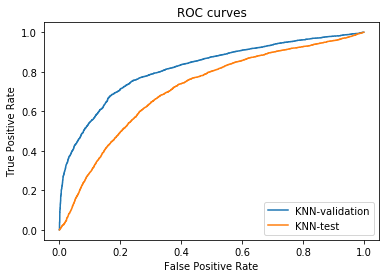

In [15]:
import matplotlib.pyplot as pl
import matplotlib
from skimage import io

fpr,tpr,thresh = sklearn.metrics.roc_curve(y,kth_nearest_dist2)

test_fpr,test_tpr,test_thresh = sklearn.metrics.roc_curve(y,test_kth_nearest_dist2)

f,ax = pl.subplots(1,1)
ax.plot(fpr,tpr,label="KNN-validation")
ax.plot(test_fpr,test_tpr,label="KNN-test")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.legend(loc="lower right")
# these are matplotlib.patch.Patch properties
#props = dict(boxstyle='square', facecolor='white', alpha=0.5)

#textstr = '$F1-binary=%.2f$\n$F1-macro=%.2f$\n$math-corcoeffient=%.2f$\n$AUC=%.2f$'%(0.7, 0.76, 0.51, 0.81)
# place a text box in upper left in axes coords
#ax.text(0.95, 0.2, textstr, transform=ax.transAxes, fontsize=13,
#    horizontalalignment='right', verticalalignment='bottom', bbox=props)

io.show()

In [ ]:
f.savefig('KNN_Gabor_50.png')